In [3]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
model_path = r"C:\Users\Ekaansh\OneDrive\Desktop\AB\vs code\JS\projects\satelite\test 2\eurosat_resnet18.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)  # EuroSAT has 10 classes
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_4888\1956514102.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a fu

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
img_size = 64
mean = [0.3443, 0.3801, 0.4082]
std = [0.1909, 0.1511, 0.1475]

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

img_path = r"C:\Users\Ekaansh\Downloads\668ed88f4121ad584885a2a5_64da35f703a3998e7f2a50a0_image3-min.png"
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

In [7]:
def generate_gradcam(model, target_layer, input_tensor):
    features = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal features
        features = output.detach()

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()

    # Register hooks
    handle_fwd = target_layer.register_forward_hook(forward_hook)
    handle_bwd = target_layer.register_full_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backward pass for predicted class
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0][pred_class] = 1
    output.backward(gradient=one_hot)

    # Compute Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    features[0] *= pooled_gradients.view(-1, 1, 1)  # broadcast safe

    heatmap = features[0].mean(dim=0).cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() != 0:
        heatmap /= heatmap.max()

    # Clean hooks
    handle_fwd.remove()
    handle_bwd.remove()

    return heatmap, pred_class

In [8]:
heatmap_l4, pred_class = generate_gradcam(model, model.layer4[-1].conv2, input_tensor)
heatmap_l3, _ = generate_gradcam(model, model.layer3[-1].conv2, input_tensor)

c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [9]:
def overlay_heatmap(img, heatmap):
    heatmap_resized = cv2.resize(heatmap, (img.width, img.height))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap_resized, 0.4, 0)
    return superimposed_img

overlay_l4 = overlay_heatmap(img, heatmap_l4)
overlay_l3 = overlay_heatmap(img, heatmap_l3)


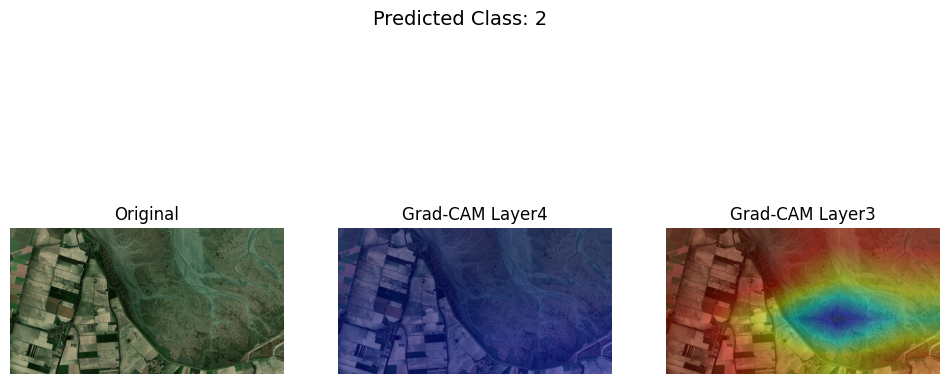

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(img); plt.axis('off'); plt.title("Original")
plt.subplot(1, 3, 2); plt.imshow(overlay_l4); plt.axis('off'); plt.title("Grad-CAM Layer4")
plt.subplot(1, 3, 3); plt.imshow(overlay_l3); plt.axis('off'); plt.title("Grad-CAM Layer3")
plt.suptitle(f"Predicted Class: {pred_class}", fontsize=14)
plt.show()